In [1]:
import os
import pickle
from typing import Callable, Tuple

import cv2
import matplotlib.pyplot as plt
import numpy as np
import segmentation_models_pytorch as smp
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class GliomaDataset(Dataset):
    def __init__(self, metadata_df_path, labels_path, transform=None):
        with open(metadata_df_path, "rb") as f:
            self.metadata_df = pickle.load(f)

        self.metadata_df = self.metadata_df[
            self.metadata_df["Patient_ID"] != "PatientID_0191"
        ]
        with open(labels_path, "rb") as f:
            self.labels = pickle.load(f)

        self.data_root = "./Preprocessed-Data"
        self.transform = transform

    def __len__(self):
        return len(self.metadata_df)

    def __getitem__(self, idx):
        row = self.metadata_df.iloc[idx]
        patient_id = row["Patient_ID"]
        regions = np.load(
            self.data_root + f"/{patient_id}/{patient_id}_regions.npy"
        )
        mri = np.load(self.data_root + f"/{patient_id}/{patient_id}_mri.npy")
        tumor = np.load(
            self.data_root + f"/{patient_id}/{patient_id}_tumor.npy"
        )

        if self.transform:
            mri = self.transform(mri)
            regions = self.transform(regions)
            tumor = self.transform(tumor)

        return {
            "mri": mri,
            "tumor": tumor,
            "regions": regions,
        }


def image_only_collate_fn(batch):
    mri = torch.stack([torch.tensor(it["mri"]) for it in batch]).unsqueeze(1)
    y = torch.stack([torch.tensor(it["tumor"]) for it in batch]).unsqueeze(1)

    regs = torch.stack([torch.tensor(it["regions"]) for it in batch]).unsqueeze(
        1
    )
    x = torch.cat([mri.float(), regs.float()], dim=1)

    return {"x": x, "y": y.float()}

In [4]:
def normalize_gray(image: np.ndarray) -> np.ndarray:
    result = np.transpose(image, (1, 2, 0))
    norm = (result - result.mean()) / result.std()
    norm = norm * 0.1
    norm = norm + 0.5
    norm = norm.clip(0, 1)
    return norm


def normalize(cam: np.ndarray) -> np.ndarray:
    return np.float32([(x - x.min()) / (x.max() - x.min() + 1e-7) for x in cam])


def scale(cam: np.ndarray, target_size: Tuple[int, int]) -> np.ndarray:
    return np.float32([cv2.resize(x, target_size) for x in cam])

In [5]:
class GradCAM:
    def __init__(self, model: nn.Module, target_layer: nn.Module) -> None:
        self.model = model
        self.model.eval()
        self.activations = None
        self.gradients = None
        target_layer.register_forward_hook(self.forward_hook)
        target_layer.register_full_backward_hook(self.backward_hook)

    def forward_hook(
        self, _module: nn.Module, _input: torch.Tensor, output: torch.Tensor
    ) -> None:
        self.activations = output

    def backward_hook(
        self,
        _module: nn.Module,
        _grad_input: torch.Tensor,
        grad_output: torch.Tensor,
    ) -> None:
        self.gradients = grad_output[0]

    @torch.no_grad()
    def _infer_target_size(self, image: torch.Tensor) -> Tuple[int, int]:
        # cv2.resize expects (width, height)
        h, w = int(image.shape[-2]), int(image.shape[-1])
        return (w, h)

    def __call__(self, image: torch.Tensor) -> Tuple[np.ndarray, np.ndarray]:
        """Grad-CAM for segmentation via an overall-confidence scalar objective.

        For binary segmentation with UNet output logits of shape (B, 1, H, W),
        we define a scalar score as mean(sigmoid(logits)) and backprop it.

        Returns:
            heatmap: (B, H, W) normalized Grad-CAM heatmap
            pred_mask: (B, H, W) predicted segmentation mask (sigmoid of logits)
        """
        mask_logits = self.model(image)  # (B, 1, H, W)
        mask_probs = torch.sigmoid(mask_logits)
        pred_mask = mask_probs.squeeze(1).detach().cpu().numpy()  # (B, H, W)
        pred_mask = (pred_mask > 0.5).astype(np.float32)

        score = mask_probs.mean()
        self.model.zero_grad(set_to_none=True)
        score.backward()

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)  # (B, C, 1, 1)
        heatmap = (weights * self.activations).sum(dim=1)  # (B, h, w)
        heatmap = F.relu(heatmap)

        heatmap = heatmap.detach().cpu().numpy()
        heatmap = normalize(heatmap)
        heatmap = scale(heatmap, self._infer_target_size(image))

        return heatmap, pred_mask

In [6]:
def build_unet(
    encoder_name: str,
    encoder_weights: str = "imagenet",
    in_channels: int = 2,
    classes: int = 1,
) -> smp.Unet:
    return smp.Unet(
        encoder_name=encoder_name,
        encoder_weights=encoder_weights,
        in_channels=in_channels,
        classes=classes,
    )


def build_deeplabv3p(
    encoder_name: str,
    in_channels: int = 2,
    classes: int = 1,
) -> smp.DeepLabV3Plus:
    return smp.DeepLabV3Plus(
        encoder_name=encoder_name,
        encoder_weights=None,
        in_channels=in_channels,
        classes=classes,
    )


def load_model_dlv3p(
    encoder_name: str, ckpt_path: str, in_channels: int
) -> smp.DeepLabV3Plus:
    assert os.path.isfile(ckpt_path), f"Missing checkpoint: {ckpt_path}"
    m = build_deeplabv3p(encoder_name, in_channels=in_channels, classes=1).to(
        DEVICE
    )
    m.load_state_dict(torch.load(ckpt_path, map_location=DEVICE), strict=True)
    m.eval()
    return m


def load_model_unet(
    encoder_name: str, ckpt_path: str, in_channels: int
) -> smp.Unet:
    assert os.path.isfile(ckpt_path), f"Missing checkpoint: {ckpt_path}"
    m = build_unet(
        encoder_name, "imagenet", in_channels=in_channels, classes=1
    ).to(DEVICE)
    m.load_state_dict(torch.load(ckpt_path, map_location=DEVICE))
    m.eval()
    return m

In [7]:
def load_model_from_ckpt(ckpt_path: str) -> nn.Module:
    if "deeplabv3" in ckpt_path:
        return load_model_dlv3p(
            "timm-mobilenetv3_small_100", ckpt_path, in_channels=2
        )
    if "mit" in ckpt_path:
        return load_model_unet("mit_b3", ckpt_path, in_channels=2)

    return load_model_unet("resnet50", ckpt_path, in_channels=2)


def get_target_layer(model: nn.Module) -> nn.Module:
    if isinstance(model, smp.DeepLabV3Plus):
        return model.decoder.aspp
    return model.decoder.blocks[-1]

In [8]:
dataset = GliomaDataset(
    "./cleaned_df.pkl",
    "./labels_list.pkl",
)
dataloader = DataLoader(
    dataset, batch_size=32, shuffle=False, collate_fn=image_only_collate_fn
)

In [9]:
def visualize_gradcam(
    load_model_fn: Callable[[str], nn.Module],
    get_target_layer_fn: Callable[[nn.Module], nn.Module],
    dataloader: DataLoader,
    sample_idx: int = 0,
    alpha: float = 0.45,
    title: str = "",
    axes: np.ndarray = None,
) -> None:
    """Load model, compute Grad-CAM, and plot original/overlay/predicted/ground-truth."""
    # Setup Grad-CAM on last decoder block
    model = load_model_fn()
    target_layer = get_target_layer_fn(model)
    cam = GradCAM(model, target_layer)

    # Get a single sample
    batch = next(iter(dataloader))
    x = batch["x"][sample_idx].unsqueeze(0).float().to(DEVICE)
    heatmap, pred_mask = cam(x)
    heatmap = heatmap[0]  # (H, W)
    pred_mask = pred_mask[0]  # (H, W)

    # Prepare visualization data
    mri_np = batch["x"][sample_idx, 0].detach().cpu().numpy()
    mri_norm = (mri_np - mri_np.min()) / (mri_np.max() - mri_np.min() + 1e-7)
    orig_rgb = np.stack([mri_norm] * 3, axis=-1)

    hm_u8 = (heatmap * 255).clip(0, 255).astype(np.uint8)
    hm_color = cv2.applyColorMap(hm_u8, cv2.COLORMAP_JET)
    hm_color = cv2.cvtColor(hm_color, cv2.COLOR_BGR2RGB) / 255.0

    overlay = ((1 - alpha) * orig_rgb + alpha * hm_color).clip(0, 1)
    gt = batch["y"][sample_idx].detach().cpu().numpy().squeeze()

    # Plot: Original, GradCAM overlay, Predicted mask, Ground-truth mask
    if axes is None:
        fig, axes = plt.subplots(1, 4, figsize=(18, 5))
        if title:
            fig.suptitle(title, fontsize=14, fontweight="bold")
        standalone = True
    else:
        standalone = False

    axes[0].imshow(orig_rgb)
    axes[0].axis("off")
    if title and not standalone:
        # Add row label to the left of the first image
        axes[0].text(
            -0.15,
            0.5,
            title,
            transform=axes[0].transAxes,
            fontsize=10,
            fontweight="bold",
            ha="center",
            va="center",
            rotation=90,
        )

    axes[1].imshow(overlay)
    axes[1].axis("off")

    axes[2].imshow(pred_mask, cmap="gray")
    axes[2].axis("off")

    axes[3].imshow(gt, cmap="gray")
    axes[3].axis("off")

    if standalone:
        axes[0].set_title("Original (MRI)")
        axes[1].set_title("GradCAM overlay")
        axes[2].set_title("Predicted mask")
        axes[3].set_title("Ground-truth mask")
        plt.tight_layout()
        plt.show()

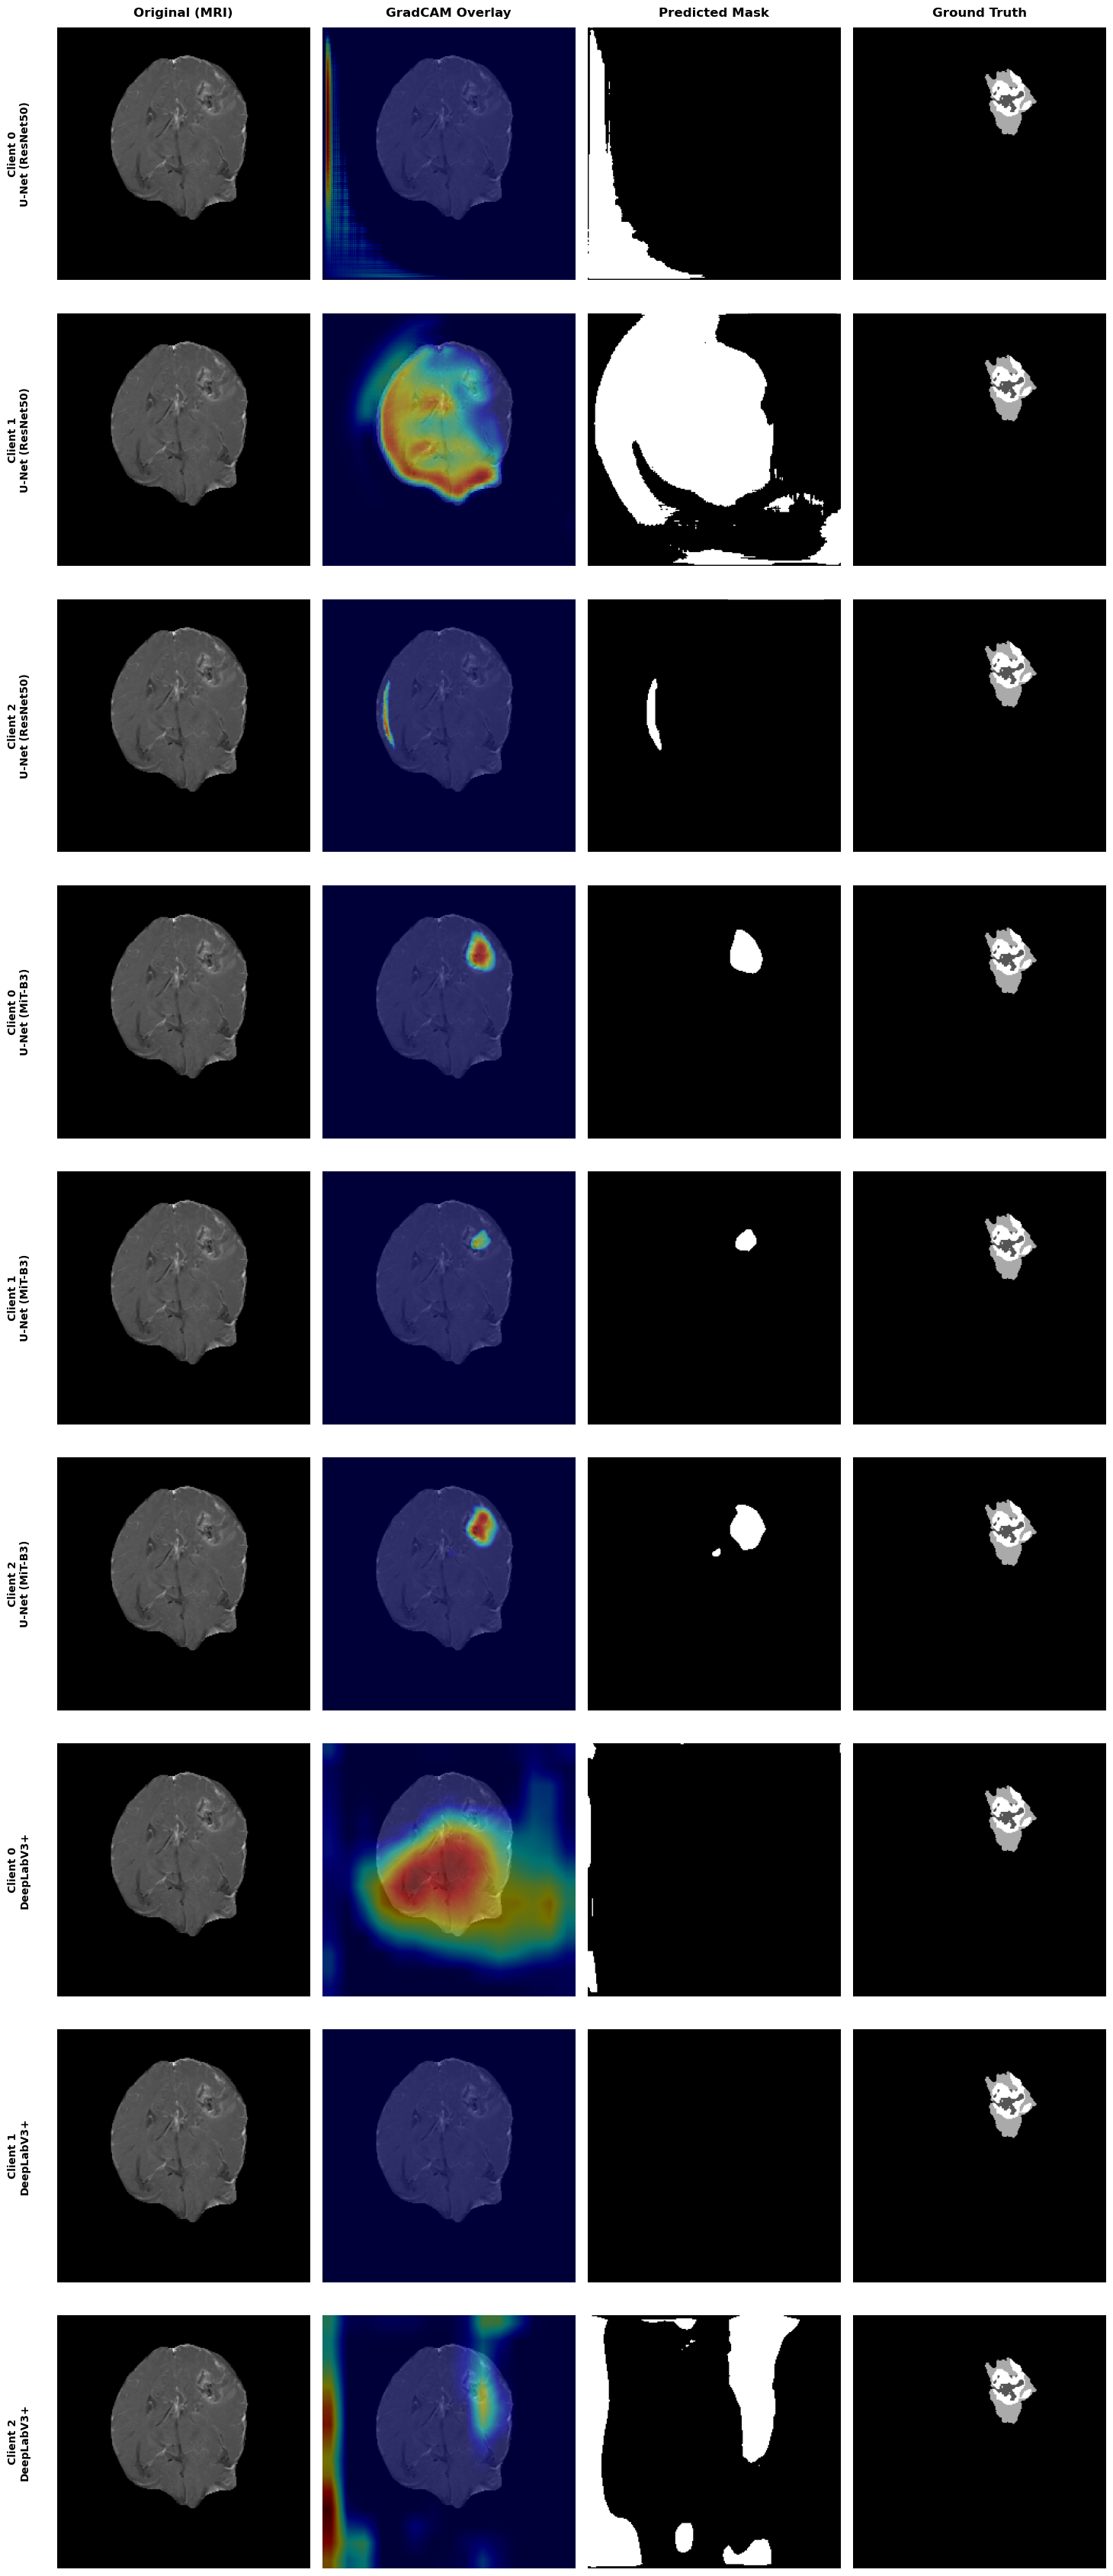

In [10]:
checkpoint_paths = []
for dirpath, dirname, filenames in os.walk("./final_models"):
    if "checkpoints" in dirpath:
        checkpoint_paths.extend(
            [
                os.path.join(dirpath, filename)
                for filename in filenames
                if filename.endswith(".pt")
            ]
        )

# Create a single figure with all plots stacked vertically
n_models = len(checkpoint_paths)
fig, all_axes = plt.subplots(n_models, 4, figsize=(16, 4 * n_models))

# Handle case where there's only one model (axes won't be 2D)
if n_models == 1:
    all_axes = all_axes.reshape(1, -1)

# Add column titles only to the first row
col_titles = [
    "Original (MRI)",
    "GradCAM Overlay",
    "Predicted Mask",
    "Ground Truth",
]
for col_idx, col_title in enumerate(col_titles):
    all_axes[0, col_idx].set_title(
        col_title, fontsize=12, fontweight="bold", pad=10
    )

for row_idx, (i, ckpt_path) in enumerate(zip((0, 1, 2) * 3, checkpoint_paths)):
    model_name = ckpt_path.split("/")[-3]
    if "deeplabv3" in ckpt_path:
        model_name = "DeepLabV3+"
    else:
        if "mit" in ckpt_path:
            model_name = "U-Net (MiT-B3)"
        else:
            model_name = "U-Net (ResNet50)"

    visualize_gradcam(
        load_model_fn=lambda ckpt_path=ckpt_path: load_model_from_ckpt(
            ckpt_path
        ),
        get_target_layer_fn=get_target_layer,
        dataloader=dataloader,
        sample_idx=0,
        title=f"Client {i}\n{model_name}",
        axes=all_axes[row_idx],
    )

plt.subplots_adjust(
    left=0.12, right=0.98, top=0.95, bottom=0.02, hspace=0.08, wspace=0.05
)
plt.show()